In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
!ls /content/gdrive/My\ Drive/
root_path = 'gdrive/My Drive/'
os.chdir('gdrive/My Drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········


Imports:


In [4]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import keras.preprocessing
import tensorflow as tf
import numpy as np
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
import pickle

Utils to use in this jupyter:

In [50]:
def df_to_tensor(df):
  rev_tensor = tf.data.Dataset.from_tensor_slices([tf.convert_to_tensor(e) for e in df.review])
  #sent_tensor = tf.data.Dataset.from_tensor_slices([tf.convert_to_tensor(e, dtype=tf.int64) for e in df.sentiment])
  sent_tensor = tf.data.Dataset.from_tensor_slices(tf.one_hot(df.sentiment, depth=3))
  return tf.data.Dataset.zip((rev_tensor, sent_tensor)).prefetch(1)

def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 2000)
    X_batch = tf.strings.regex_replace(X_batch, b"<br\\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

def plot_metric(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

#to re-write:
def sample_predict(sample_pred_texts, table):
    rev_tensor = tf.convert_to_tensor(sample_pred_texts)
    X = tf.strings.substr(rev_tensor, 0, 2000)
    X = tf.strings.regex_replace(X, b"<br\\s*/?>", b" ")
    X = tf.strings.regex_replace(X, b"[^a-zA-Z']", b" ")
    X = tf.strings.split(X)
    X = X.to_tensor(default_value=b"<pad>")
    return table.lookup(X)

def decode(predictions):
    codex = {'0':'Negative', '1':'Neutral', '2':'Positive'}
    return [codex[str(np.argmax(e))] for e in predictions]  

def load_vocabulary(vocab_file, num_oov_buckets = 5000):
    words = tf.constant(vocab_file)
    word_ids = tf.range(len(vocab_file), dtype=tf.int64)
    vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
    return tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

## Loading data

First we load the data from the repository that I created:

In [27]:
#data_url = 'https://raw.githubusercontent.com/DavidCarricondo/Custom-database-goodreads-reviews/master/DATA/goodreads_reviews_clean.csv'
#data = pd.read_csv(data_url)
data_path = '../INPUT/goodreads_reviews_clean.csv'
data = pd.read_csv(data_path)
data.head()

,review,grade,lang,score,sentiment
0,"The statue of Hadrian, the 14th Emperor of the...",it was amazing,en,4,2
1,It's hard to know what to think about this boo...,really liked it,en,3,2
2,"If you're into stuff like this, you can read t...",it was amazing,en,4,2
3,Has Kenzaburo Oe ever visited Japan? Ban this ...,it was amazing,en,4,2
4,Sadza (typical cornmeal staple food in Zimbabw...,it was amazing,en,4,2


Now, let's shuffle the data and then split it into train, validation, and test data (90%, 5%, 5% respectively), and then convert it to tensorflow tensors

In [28]:
data = data.sample(frac=1).reset_index(drop=True)

train_size = len(data) * 90//100
valtest_size = (len(data)-train_size)//2

data_train = data[:train_size]
data_val = data[train_size:(train_size+valtest_size)]
data_test = data[(train_size+valtest_size):]

In [29]:
data_train = df_to_tensor(data_train)
data_val = df_to_tensor(data_val)
data_test = df_to_tensor(data_test)

In [30]:
type(data_train)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

## Creating vocabulary

Now we create a vocabulary and assign an index to each word:

In [31]:
#The counter object will just count into a dictionary the number of instances of each element (word in this case) in an object
vocabulary = Counter()
for X_batch, y_batch in data_train.batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [32]:
vocabulary.most_common()[:3]

[(b'<pad>', 3758660), (b'the', 184135), (b'of', 113296)]

In [33]:
len(vocabulary)

86672

We can also truncate the vocabulary to use only the 10000 most common words:

In [34]:
vocab_size = 10000
truncated_vocabulary = [word for word, count in vocabulary.most_common()[:vocab_size]]

And now, we create a lookup table with the word indexes plus 1000 out of the dictionary buckets to transform the reviews to their word indexes in the vocabulary:

In [35]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [36]:
table.lookup(tf.constant([b'this book was very good and the author guapisimo'.split()]))

<tf.Tensor: shape=(1, 9), dtype=int64, numpy=array([[   11,    13,    12,    66,    97,     3,     1,   125, 10839]])>

Note that "guapisimo" is not in the dictionary and therefore it's assigned an index greater than 10000.

In [37]:
table


In [38]:
with open('../OUTPUT/vocabulary', 'wb') as f:
    pickle.dump(truncated_vocabulary, f)
f.close()

## Reviews preprocessing and encoding

Now we are ready to use the reviews. First we batch the data, then we preprocess it, and then we encode them. All of it using the functions defined above:


In [61]:
train_set = data_train.batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

val_set = data_val.batch(32).map(preprocess)
val_set = val_set.map(encode_words).prefetch(1)

test_set = data_test.batch(32).map(preprocess)
test_set = test_set.map(encode_words).prefetch(1)

## Modelling

In [62]:
embed_size = 128

inputs = tf.keras.layers.Input(shape=[None])
mask = tf.keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)

z = tf.keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.4, recurrent_dropout=0.4))(z, mask=mask)
z = tf.keras.layers.LSTM(128, dropout=0.4, recurrent_dropout=0.4)(z, mask=mask)
outputs = keras.layers.Dense(3, activation='softmax')(z)

model = keras.Model(inputs=[inputs], outputs=[outputs])

model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(train_set, validation_data=val_set, epochs=15)

model.save('../OUTPUT/models/model_custom_rnn.h5')

Epoch 1/15
634/634 [==============================] - 1818s 3s/step - loss: 1.0389 - accuracy: 0.4445 - val_loss: 0.9616 - val_accuracy: 0.5311
Epoch 2/15
634/634 [==============================] - 1867s 3s/step - loss: 0.8873 - accuracy: 0.5736 - val_loss: 0.9573 - val_accuracy: 0.5160
Epoch 3/15
634/634 [==============================] - 2138s 3s/step - loss: 0.7312 - accuracy: 0.6796 - val_loss: 0.9937 - val_accuracy: 0.5222
Epoch 4/15
634/634 [==============================] - 1890s 3s/step - loss: 0.5865 - accuracy: 0.7637 - val_loss: 1.0498 - val_accuracy: 0.5524
Epoch 5/15
634/634 [==============================] - 1523s 2s/step - loss: 0.4779 - accuracy: 0.8149 - val_loss: 1.1920 - val_accuracy: 0.5320
Epoch 6/15
634/634 [==============================] - 1485s 2s/step - loss: 0.3867 - accuracy: 0.8552 - val_loss: 1.3729 - val_accuracy: 0.5373
Epoch 7/15
634/634 [==============================] - 1485s 2s/step - loss: 0.3199 - accuracy: 0.8848 - val_loss: 1.5054 - val_accuracy:

In [63]:
test_loss, test_acc = model.evaluate(test_set)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

36/36 [==============================] - 18s 495ms/step - loss: 2.3398 - accuracy: 0.5142
Test Loss: 2.3397538661956787
Test Accuracy: 0.5142095685005188


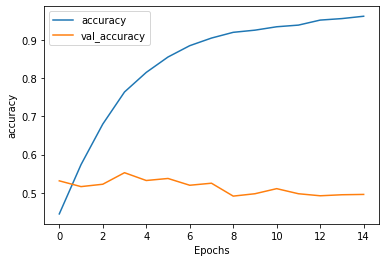

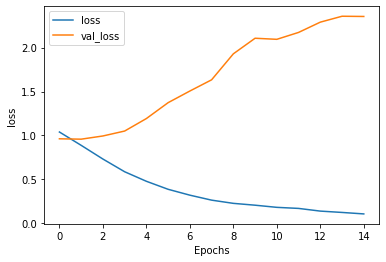

In [64]:
plot_metric(history, 'accuracy')
plot_metric(history, 'loss')

In [65]:
test = sample_predict(['such a good book', 'meh, it was ok'], table)
test

<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[ 162,    4,   98,   13],
       [5521,   10,   12, 1869]])>

In [66]:
pred = model.predict(test)
pred

array([[0.29180074, 0.28995147, 0.41824782],
       [0.02009744, 0.9758655 , 0.00403704]], dtype=float32)

In [67]:
decode(pred)

['Positive', 'Neutral']

Now, for production purpuses, we need to load the model and dictionary from memory and predict from there:

In [40]:
#Load model:
model = load_model('../OUTPUT/models/model_custom_rnn.h5')
#Load vocabulary file and create the statictable:
with open('../OUTPUT/vocabulary', 'rb') as f:
    vocab = pickle.load(f)
f.close()
table = load_vocabulary(vocab, num_oov_buckets = 1000)

In [41]:
test = sample_predict(['such a good book', 'meh, it was ok'], table)
pred = model.predict(test)
decode(pred)

['Neutral', 'Negative']

In [52]:
data[data.sentiment==0]

,review,grade,lang,score,sentiment
7,A requirement for my second year book report. ...,it was ok,en,1,0
9,the most interesting thing about this book wer...,did not like it,en,0,0
11,"It hurts having to give such a rating, special...",it was ok,en,1,0
23,The need for a Marias book is a physical uncom...,it was ok,en,1,0
25,Wow - this book goes from one extreme to the o...,did not like it,en,0,0
...,...,...,...,...,...
22490,"Sliding from weak metaphor to weak metaphor, ""...",it was ok,en,1,0
22497,Amitav Ghosh's attempt to bring together one's...,it was ok,en,1,0
22499,I had to abandon this book part way in - I hon...,did not like it,en,0,0
22500,I feel kind of bad giving this two stars. On t...,it was ok,en,1,0


In [7]:
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

def gr_log(driver, user, password):
    username_field = driver.find_element_by_id("userSignInFormEmail")
    password_field = driver.find_element_by_id("user_password")

    username_field.send_keys(user)
    #driver.implicitly_wait(1)
        
    password_field.send_keys(password)
    #driver.implicitly_wait(1)

    #Click the submit button (the third element formbox)
    submit = driver.find_elements_by_class_name('formBox')
    submit[2].click()

    driver.implicitly_wait(3) 

def get_book(driver, name, log=False):
    if log==True:
        try:
            inputs = driver.find_elements_by_tag_name('input')
        except:
            raise ValueError('I do not seem to find that book')    
        #The search box is the first input tag
        search_box = 0
        for i in inputs:
            search_box = i
            break
    else:
        search_box = driver.find_element_by_id('sitesearch_field')        
    #Input the book name and hit enter
    search_box.send_keys(name)
    search_box.send_keys(Keys.RETURN)

    #close log-in banner
    close_button_path = "/html/body/div[3]/div/div/div[1]" 
    wait = WebDriverWait(driver, 10)
    close_button = wait.until(EC.visibility_of_element_located((By.XPATH, close_button_path)))
    close_button .click()

    #SELECT THE FIRST INSTANCE
    driver.find_element_by_class_name('bookTitle').click()

def get_GR_reviews(driver):
    reviews_container = driver.find_elements_by_class_name('review')

    reviews = {}

    for i, e in enumerate(reviews_container):
        try:
            read = e.find_element_by_class_name('readable')
        except:
            continue
        try:
            read.find_element_by_link_text('...more').click()
        except:
            pass
        rev = read.find_elements_by_tag_name('span')
        reviews[i] = (rev[0].text if len(rev)==1 else rev[1].text)
    return reviews

def get_title_and_pic(driver):

    title = driver.find_element_by_id('bookTitle').text
    
    author = driver.find_element_by_id('bookAuthors')
    authors = author.find_elements_by_class_name('authorName')
    aut = ', '.join([aut.text for aut in authors])

    pic = driver.find_element_by_id('coverImage').get_attribute("src")

    return title.upper(), aut, pic



    


In [8]:
import os
import dotenv
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
import json

dotenv.load_dotenv()


def GR_scrapping(DRIVER, BOOK_NAME, GR_PASS=None, GR_USER=None):
    driver = webdriver.Chrome(DRIVER)

    #Open web:
    driver.get('https://www.goodreads.com/')
    driver.implicitly_wait(2)


    ###LOG IN TO GOODREADS ACCOUNT:
    #gr_log(driver, GR_USER, GR_PASS)


    ###FIND A BOOK
    get_book(driver, BOOK_NAME, log=False)
    driver.implicitly_wait(4)


    #GET THE REVIEWS
    title, author, pic = get_title_and_pic(driver)
    reviews = get_GR_reviews(driver)

    #Save json:
    #with open('OUTPUT/data.json', 'w') as fp:
    #    json.dump(reviews, fp)

    driver.quit()

    return reviews, title, author, pic

In [10]:
reviews, _, _, _ = GR_scrapping('/home/david/Chrome_web_driver/chromedriver', 'of mice and men')

In [23]:
revs = [rev for key, rev in reviews.items()]

In [42]:
test = sample_predict(revs[:2], table)
pred = model.predict(test)
decode(pred)

['Neutral', 'Positive']

In [44]:
sample_predict(['such a good book', 'meh, it was ok'], table)

<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[ 163,    4,   97,   13],
       [5131,   10,   12, 1885]])>

In [46]:
coded_revs = sample_predict(revs, table)

In [47]:
pred = model.predict(coded_revs)
decode(pred)

['Neutral',
 'Positive',
 'Neutral',
 'Negative',
 'Positive',
 'Neutral',
 'Neutral',
 'Negative',
 'Neutral',
 'Positive',
 'Neutral',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Neutral',
 'Neutral',
 'Positive',
 'Negative',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Neutral',
 'Neutral',
 'Neutral',
 'Negative',
 'Negative',
 'Positive']

In [49]:
maxim = 0
for e in coded_revs:
    if max(e)>maxim:
        maxim = max(e)
print(maxim)

tf.Tensor(10998, shape=(), dtype=int64)


In [ ]:
embed_size = 128

model_simple = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size, input_shape=[None]),
    tf.keras.layers.GRU(128, return_sequences=True, ),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_simple.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])

history = model_simple.fit(train_set, validation_data=val_set, epochs=10)